In [ ]:
import numpy as np
import imp
import environment
import ddpg_torch
imp.reload(environment)
from environment import Economical_env
imp.reload(ddpg_torch)
from ddpg_torch import Agent

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
env = Economical_env()

In [ ]:
agent = Agent(alpha=0.00002, beta=0.0002, input_dims=[env.observation_space_dimension()], tau=0.0005, env=env,
              batch_size=256,  layer1_size=400, layer2_size=300, n_actions=env.action_space_dimension())

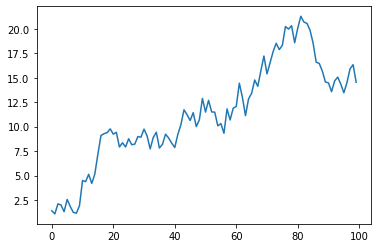

In [ ]:
obs = env.reset()
import matplotlib.pyplot as plt
pros = []
for i in range(100):
    action = agent.choose_action(obs)
    pros.append(action)
plt.plot(pros)
plt.show()

episode  34000 score 15.94 trailing 100 games avg 15.920 max_rew 15.967


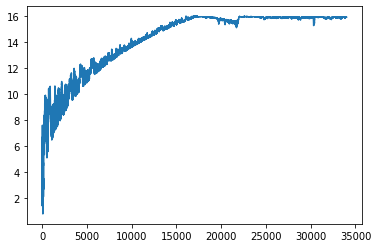

In [ ]:
from IPython.display import clear_output
#agent.load_models()
np.random.seed(0)
max_rew = 0
score_history = []
for i in range(35000):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        act = agent.choose_action(obs)
#        print(act, done)
        new_state, reward, done = env.step(act[0])
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state
        #env.render()
    score_history.append(score)

#     if i % 25 == 0:
#         agent.save_models()
    # if np.mean(score_history[-1000:]) < np.mean(score_history[-2000:]):
    #   break
                                               
    if i % 1000 == 0:
      clear_output()
      if np.mean(score_history[-1000:]) > max_rew:
        max_rew = np.mean(score_history[-1000:])
      print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-1000:]),
          'max_rew %.3f' % max_rew)
      plt.plot(score_history)
      plt.show()

In [ ]:
def choose_action(agent, observation):
    agent.target_actor.eval()
    observation = T.tensor(observation, dtype=T.float).to(agent.target_actor.device)
    mu = agent.target_actor.forward(observation).to(agent.target_actor.device)
    mu_prime = mu
    return mu_prime.cpu().detach().numpy()

In [ ]:
obs = env.reset()
done = False
score = 0
while not done:
    act = choose_action(agent, obs)
    print(act, obs)
    new_state, reward, done = env.step(act[0])
    score += reward
    obs = new_state

[389.81262] [1000.    0.    3.]
[387.892] [660.18737793   1.           2.        ]
[387.85632] [305.30474854   2.           1.        ]


In [ ]:
score

array([15.96458183])

In [ ]:
def theoretical_score(growth_rate, start_money, discount_factor):
  disc = 1 + discount_factor + discount_factor ** 2
  u_0 = start_money * growth_rate / disc
  u_1 = start_money * growth_rate ** 2 * discount_factor / disc
  u_2 = start_money * growth_rate ** 3 * discount_factor ** 2 / disc
  score = np.log(u_0) + discount_factor * np.log(u_1) + discount_factor ** 2 * np.log(u_2)
  print(discount_factor * np.log(u_1) + discount_factor ** 2 * np.log(u_2))
  print(discount_factor ** 2 * np.log(u_2))
  return score

In [ ]:
discount_factor = 0.9
print(discount_factor * np.log(382.64035) + discount_factor ** 2 * np.log(318.08737793))
print(discount_factor ** 2 * np.log(318.08737793))

10.019870118567912
4.667484155905353


In [ ]:
theoretical_score(1.5, 200, 0.9)

8.804949438972304
4.298704849978867


13.511783278736894

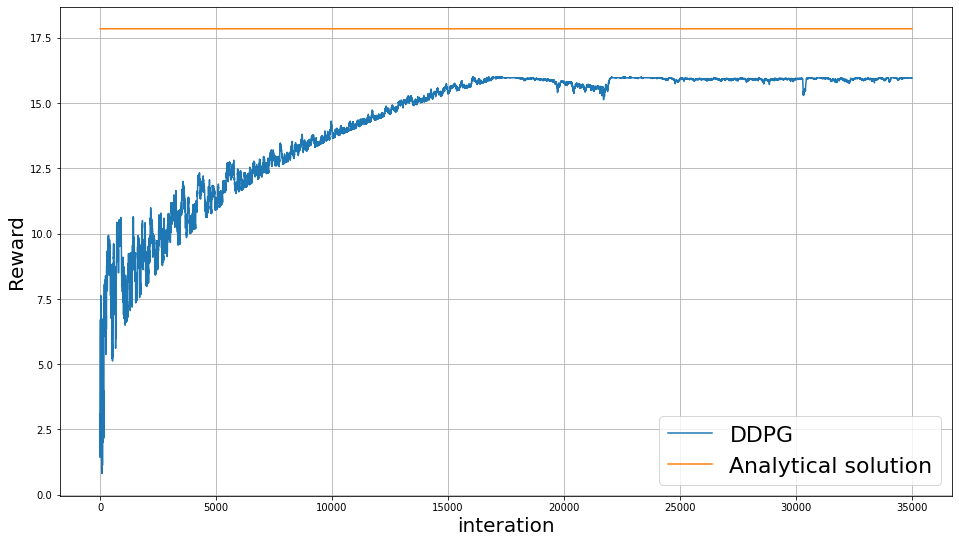

In [ ]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(score_history, label='DDPG')
ax.plot([17.84] * len(score_history), label='Analytical solution')
ax.grid()
ax.set_xlabel('interation', fontsize = 20)
ax.set_ylabel('Reward', fontsize = 20)
ax.legend(fontsize = 22)
#plt.title('Optimal consumption problem', fontsize=26)

plt.savefig(r"C:\Users\Аркадий\Desktop\1300_13_90.png")
plt.show()


In [ ]:
!pip install stable-baselines3
import gym
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make("Pendulum-v0")

# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=10)
model.save("ddpg_pendulum")
env = model.get_env()

del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_pendulum")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

In [ ]:
import random
import numpy as np
import collections

TIME_LIMIT = 3
DISCOUNT_FACTOR = 0.9
GROWTH_RATE = 1.05
START_MONEY = 1000.0

def utility_function(x):
  return np.log(x)

class Economical_env:
    '''
    time_limit-горизон планирования
    discout_factor - коэфицент дисконтирования
    growth_rate - коэффицент прироста денежных средств
    start_money - денежные активы
    '''
    def __init__(self, randomSeed = 0,
                 time_limit = TIME_LIMIT,
                 discount_factor = DISCOUNT_FACTOR,
                 growth_rate = GROWTH_RATE,
                 start_money = START_MONEY):
                 
        
        self.time_limit = time_limit
        self.discount_factor = discount_factor
        self.growth_rate = growth_rate
        self.action_space = 1
        self.observation_space = 3
#         self.start_money = start_money
#         self.start_time = 0
#         self.start_state = np.array([self.start_money, self.start_time])
        
    def reset(self, seed = 0, time = TIME_LIMIT, discount = DISCOUNT_FACTOR, g_rate = GROWTH_RATE, s_money = START_MONEY):
            self.__init__(randomSeed = seed, time_limit = time, discount_factor = discount,\
                          growth_rate = g_rate, start_money = s_money)
            self.start_money = s_money
            self.start_time = 0
            self.start_state = np.array([self.start_money, self.start_time, self.time_limit - self.start_time])
            
            return self.start_state
    
    def step(self, action):
        if action > self.growth_rate * self.start_money:
            done = True
            reward = np.log(self.start_money) * self.discount_factor ** self.start_time
            self.start_money = 0
        else:
            done = False
            reward = np.log(action) * self.discount_factor ** self.start_time
            self.start_money = self.start_money * self.growth_rate - action
        self.start_time += 1
        if self.start_time == self.time_limit:
            done = True
        
        return (np.array([self.start_money, self.start_time, self.time_limit - self.start_time]), np.array([reward]), done)
    
    def observation_space_dimension(self):
        '''размерность простравнства состояний''' 
        return 3

    def action_space_dimension(self):
        '''размерность простравнства действий''' 
        return 1

In [ ]:
env = Economical_env()

In [ ]:
# The noise objects for DDPG
n_actions = env.action_space_dimension()
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=10)
model.save("ddpg_pendulum")
env = model.get_env()

In [ ]:
import gym
from gym import spaces

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}
  def __init__(self, randomSeed = 0,
                 time_limit = TIME_LIMIT,
                 discount_factor = DISCOUNT_FACTOR,
                 growth_rate = GROWTH_RATE,
                 start_money = START_MONEY):
    self.time_limit = time_limit
    self.discount_factor = discount_factor
    self.growth_rate = growth_rate
    self.action_space = spaces.Box(low=0, high=255,
                                        shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)


  def __init__(self, arg1, arg2):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
    # Example for using image as input:
    self.observation_space = spaces.Box(low=0, high=255,
                                        shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)

  def step(self, action):
    ...
    return observation, reward, done, info

  def step(self, action):
        if action > self.growth_rate * self.start_money:
            done = True
            reward = np.log(self.start_money) * self.discount_factor ** self.start_time
            self.start_money = 0
        else:
            done = False
            reward = np.log(action) * self.discount_factor ** self.start_time
            self.start_money = self.start_money * self.growth_rate - action
        self.start_time += 1
        if self.start_time == self.time_limit:
            done = True
        
        return np.array([self.start_money, self.start_time, self.time_limit - self.start_time]), reward, done, {}
  def reset(self):
    ...
    return observation  # reward, done, info can't be included
  def render(self, mode='human'):
    ...
  def close (self):
    ...